# Time-Series-Analysis-and-Forecasting-of-Pfizer-Stock-Price-Trendsrformance.

In [1]:
pip install alpha_vantage

Note: you may need to restart the kernel to use updated packages.


In [342]:
!pip install finta

### Data gathering

In [358]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

#My API key
api_key = 'CWCUJI6SBCSZJLLZ'
#Create a TimeSeries object 
ts = TimeSeries(key=api_key, output_format='pandas')
#Retrieve weekly stock for Pfizer (PFE), Amgen (AMGN), and Merck (MRK)
pfizer, _ = ts.get_weekly(symbol='PFE')
amgen, _ = ts.get_weekly(symbol='AMGN')
merck, _ = ts.get_weekly(symbol='MRK')

In [672]:
#Loadign COVID-19 data
COVID_19 = pd.read_csv('WHO-COVID-19-global-data.csv')

### Loading the necessary libraries for the project 

In [356]:
from finta import TA
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import plotly.express as px 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Data modifying 

In [360]:
#Rename columns to remove numbers
pfizer = pfizer.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
})

amgen = amgen.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
})

merck = merck.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
})

### Basic Statistics

In [359]:
pfizer.describe().round(2)

,Open,High,Low,Close,Volume
count,1299.00,1299.00,1299.00,1299.00,1.299000e+03
mean,31.52,32.28,30.74,31.52,1.471242e+08
std,9.01,9.27,8.73,9.02,8.395796e+07
min,12.08,12.75,11.62,12.31,1.103940e+07
25%,25.40,25.84,24.80,25.33,9.106687e+07
50%,31.77,32.55,30.99,31.88,1.248161e+08
75%,37.01,37.77,36.27,36.92,1.830400e+08
max,60.60,61.71,57.16,59.48,7.512676e+08


### Merge the COVID-19 data with PFE 

In [818]:
#Convert the date in both datasets to datetime format 
COVID_19['Date_reported'] = pd.to_datetime(COVID_19['Date_reported'])
pfizer['Date'] = pd.to_datetime(pfizer.index)

#Group by 'Date_reported' and sum the 'New_cases' (in case there are multiple entries for a date)
COVID19_grouped = COVID_19.groupby('Date_reported')['New_cases'].sum().reset_index()

#Handle mismatched dates
COVID19_grouped  =  COVID19_grouped.sort_values('Date_reported')
pfizer = pfizer.sort_values('Date')

#Perform an asof merge to join Pfizer data with the nearest preivous COVID-19 date
merged_df = pd.merge_asof(pfizer, COVID19_grouped , left_on='Date', right_on='Date_reported')

In [820]:
#Data manipulation
merged_df = (merged_df.drop(columns=['Date_reported'])
             .set_index('Date')
             .rename(columns={'New_cases': 'COVID19_Cases'}))

#Fill missing values in the 'COVID19_Cases' column
merged_df['COVID19_Cases'] = merged_df['COVID19_Cases'].fillna(0)

### Correlation Analysis

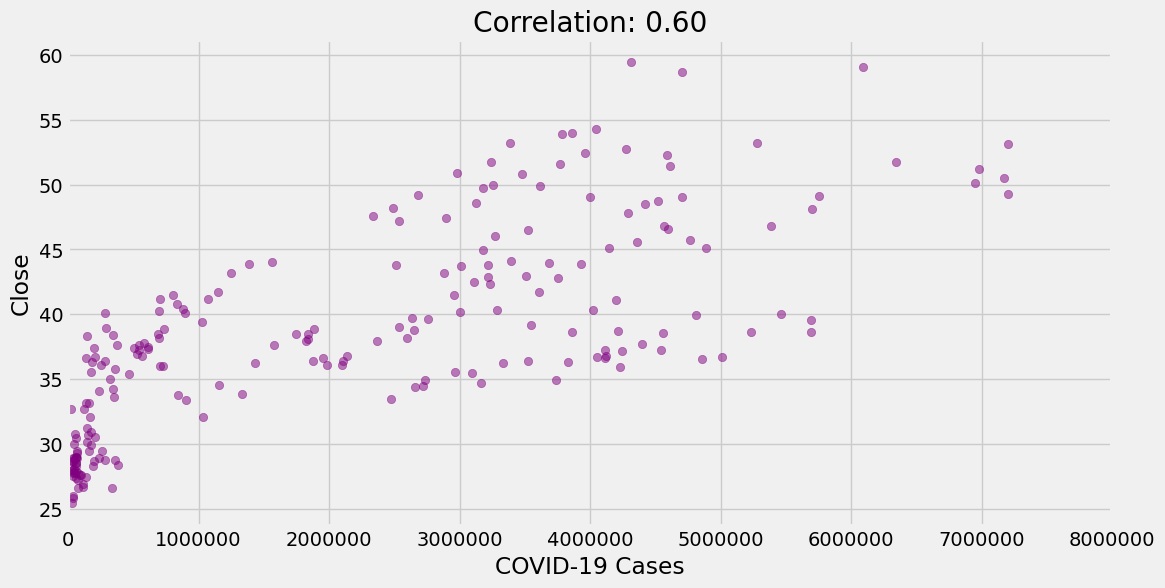

In [905]:
#WHO declared COVID-19 a pandamic on March 11, 2020
specific_date = '2020-03-11'
filtred_df = merged_df[merged_df.index > specific_date] 
#Calculate the correlation between the covid19 cases and stock price (Close)
correlation = filtred_df[['COVID19_Cases', 'Close']].corr().iloc[0, 1]
#Visualize the lagged relationship using a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(filtred_df['COVID19_Cases'], filtred_df['Close'], alpha=0.5, color='purple')
plt.title(f'Correlation: {correlation:.2f}')
plt.xlim(0, 8000000)
plt.ticklabel_format(style='plain')
plt.xlabel('COVID-19 Cases')
plt.ylabel('Close')
plt.grid(True)
plt.show()

#### There is a significant correlation of 0.60 between Pfizer's stock price and COVID-19 cases, indicating a notable relationship between the two variables. 

### Correaltion Matrix

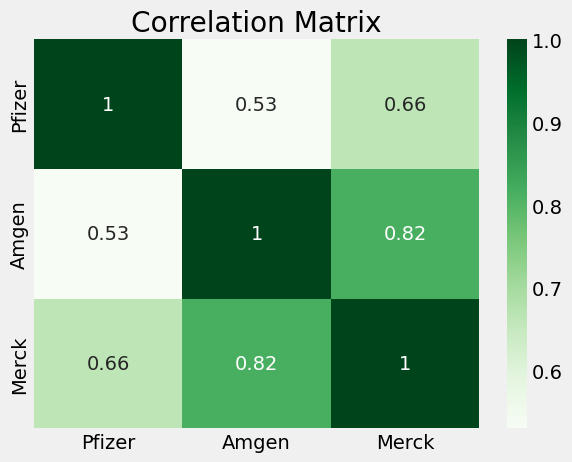

In [393]:
#Combining the 3 datasets 
portfolio = pd.concat([pfizer['Close'], amgen['Close'], merck['Close']], axis=1)
portfolio.columns = ['Pfizer', 'Amgen', 'Merck']
#Computing the correaltion 
portfolio_corr = portfolio.corr() 
#Visualizing the correlation using correaltion matrix
sns.heatmap(portfolio_corr, annot=True, cmap='Greens')
plt.title('Correlation Matrix')
plt.show()

#### This matrix shows that Pfizer's stock price increases alongside other pharmaceutical companies, with correlations greater than 0.5, indicating a strong positive relationship. 

### Event Analysis

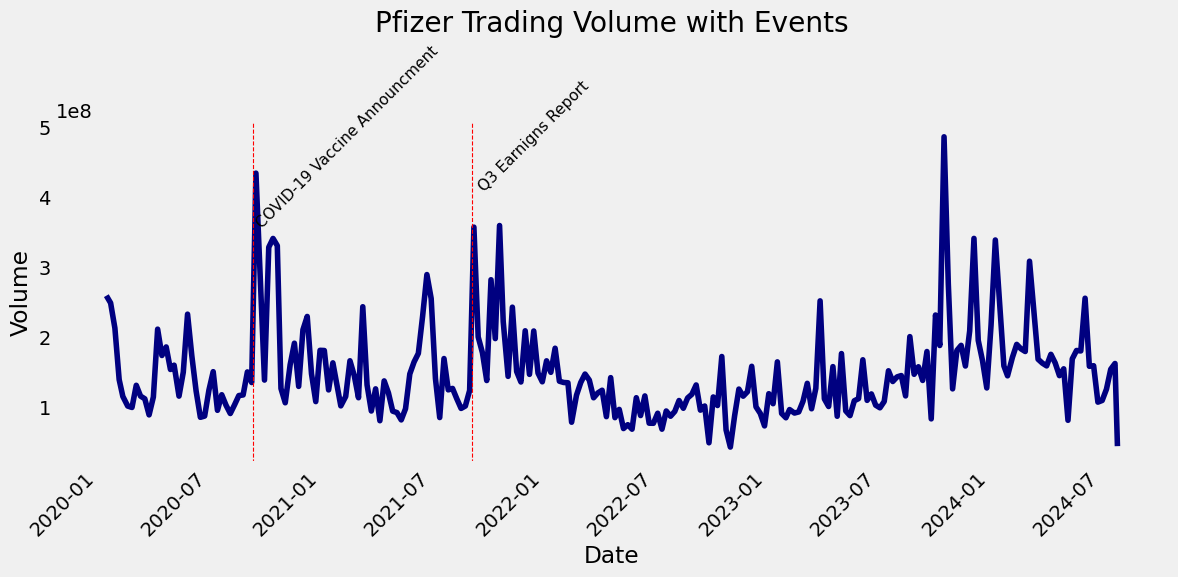

In [121]:
#Define events associated with Pfizer Stock Price 
events = [ 
    {'Date': pd.to_datetime('2020-11-09'), 'event': 'COVID-19 Vaccine Announcment'},
    {'Date': pd.to_datetime('2021-11-02'), 'event': ' Q3 Earnigns Report'}, 
]
#Plot
plt.figure(figsize=(12, 6))
plt.plot(filtred_df.index, filtred_df['Volume'], label='Volume', color='navy')
#Annotate events on the plot 
for event in events:
    plt.axvline(x=event['Date'], color='red', linestyle='--', linewidth=0.8)
    plt.text(event['Date'], filtred_df['Volume'].max(), event['event'], rotation=45, verticalalignment='center', fontsize=11)
#Plot formatting
plt.title('Pfizer Trading Volume with Events', pad=65) 
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

#### This graph illustrates Pfizer's trading volume over time, highlighting significant spikes during key events, such as the COVID-19 vaccine announcement and quarterly earnings reports. These spikes indicate increased investor interest and activity in response to major developments affecting the company.

#### Compute several technical indicators

In [930]:
#Returns
pfizer['Returns'] = pfizer['Close'].pct_change()
#Volatilty
pfizer['Volatility'] = pfizer['Returns'].rolling(window=20).std() * (252**0.5) 

#Simple Moving Average (SMA)
pfizer['SMA_50'] = TA.SMA(pfizer, 50)
pfizer['SMA_200'] = TA.SMA(pfizer, 200)

#Relative Strength Index (RSI)
pfizer['RSI'] = TA.RSI(pfizer)

#Average True Range (ATR)
pfizer['ATR'] = TA.ATR(pfizer)

### Plot the Close price along with SMAs

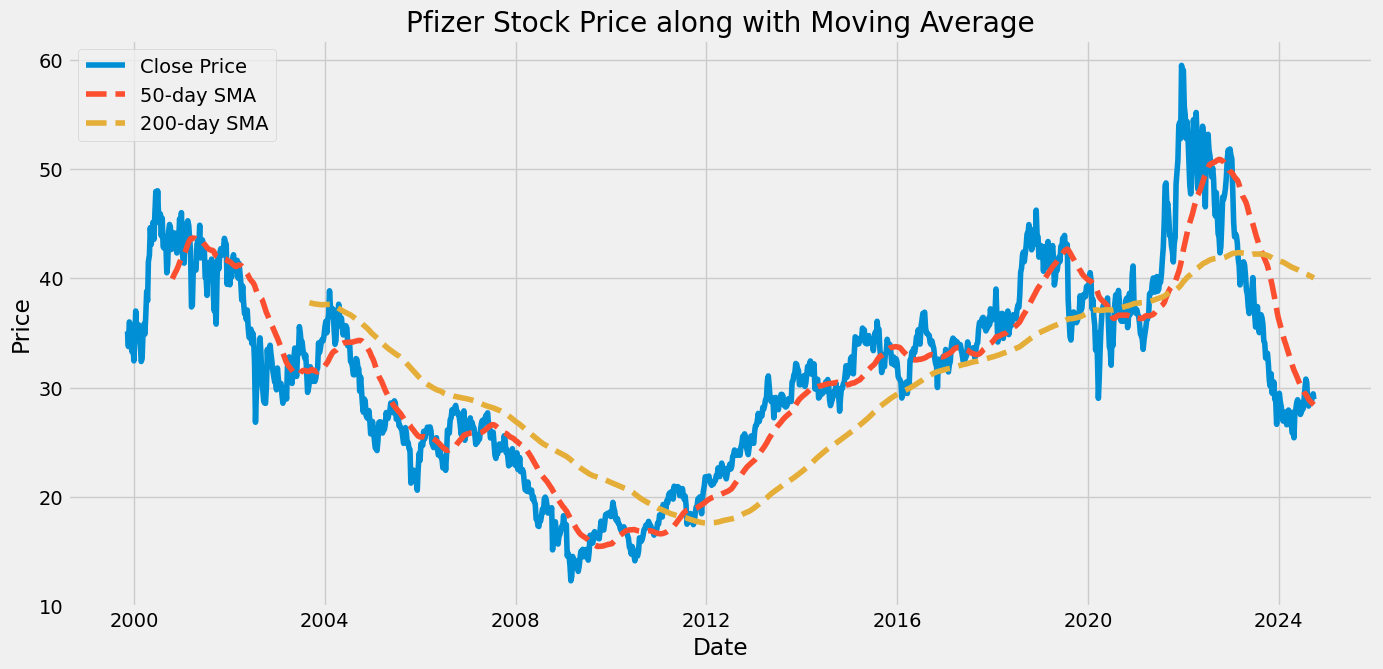

In [882]:
plt.figure(figsize=(15, 7))
plt.plot(pfizer.index, pfizer['Close'], label='Close Price')
plt.plot(pfizer.index, pfizer['SMA_50'], label='50-day SMA', linestyle='--')
plt.plot(pfizer.index, pfizer['SMA_200'], label='200-day SMA', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Pfizer Stock Price along with Moving Average')
plt.legend()
plt.grid(True)
plt.show()

#### RSI plot

Text(0, 0.5, 'RSI')

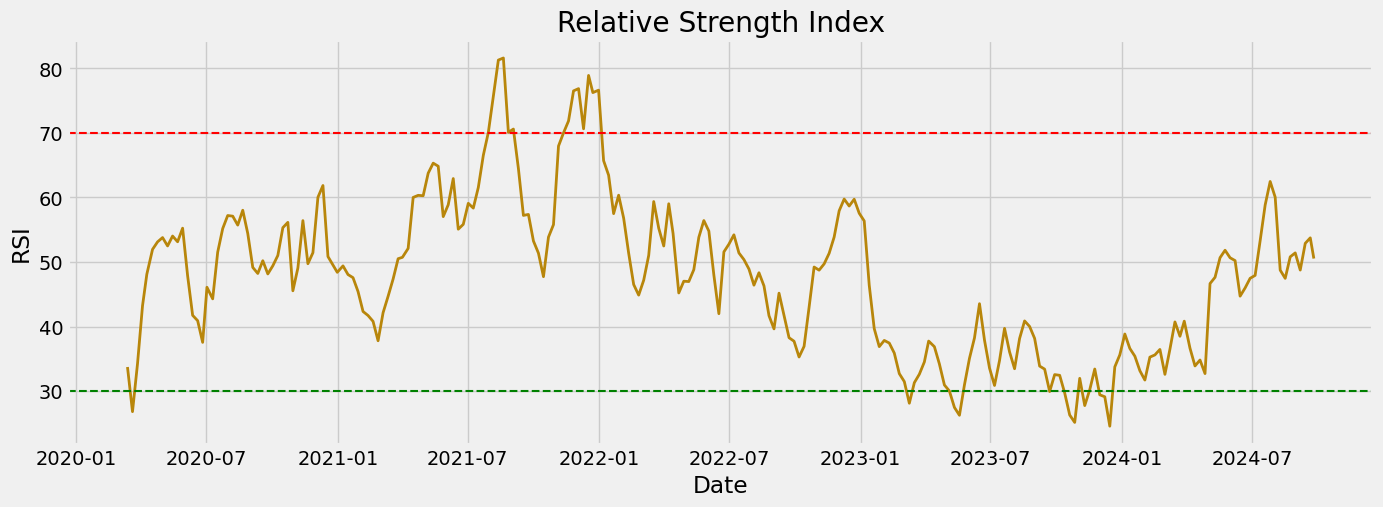

In [903]:
pfizer_20 = pfizer[pfizer.index >= '2020-03-11']
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(pfizer_20['RSI'], color='darkgoldenrod', linewidth=2)
ax1.axhline(30, linestyle='--', linewidth=1.5, color='green')
ax1.axhline(70, linestyle='--', linewidth=1.5, color='red')
ax1.set_title('Relative Strength Index')
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')

#### From this graph we can notice that the RSI exceeded 70 during late December 2020 and early March 2021, indicating overbought conditions, while it fell below 30 in May 2023, suggesting oversold conditions, which could signal potential price reversals.

#### Returns Distribution 

Text(0, 0.5, 'Frequency')

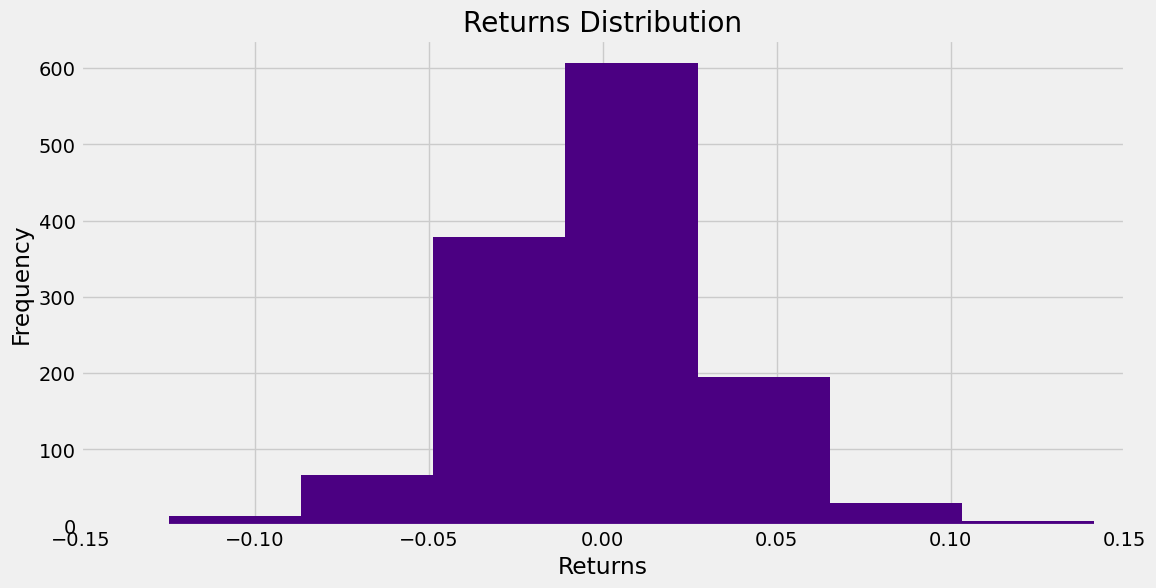

In [952]:
#Plot the returns distribution
plt.figure(figsize=(12, 6))
plt.hist(pfizer['Returns'], color = 'indigo')
plt.xlim(-0.15, 0.15)
plt.title('Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')

#### It seems that the returns are normally distributed. 

### Develop XGBoost Model

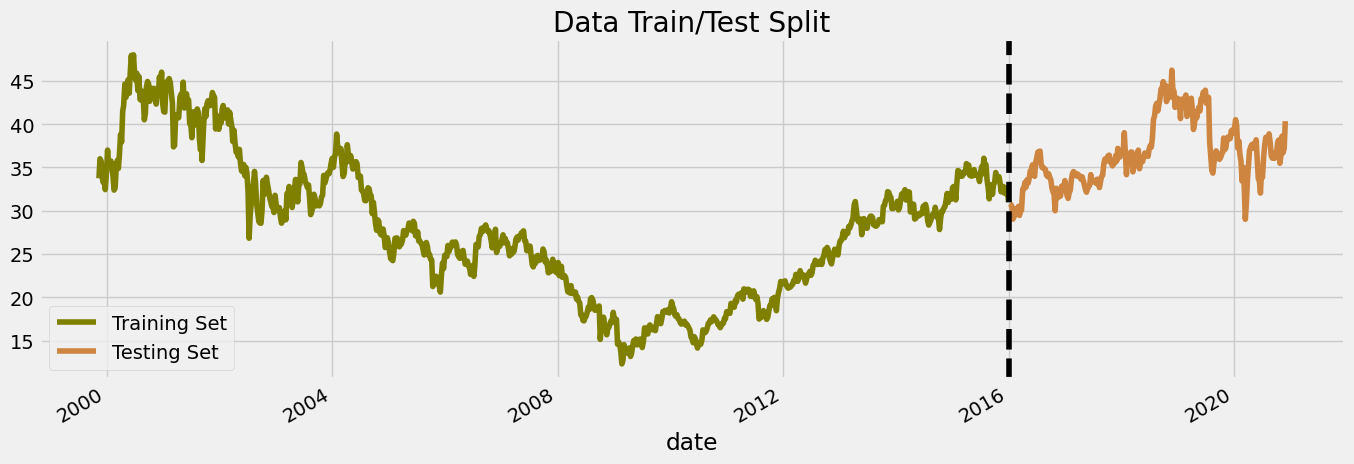

In [708]:
#Target variable 
pfizer['Target'] = pfizer.Close.shift(-1)
#Drop null values
pfizer = pfizer.dropna()
#Cross Validation 
train = pfizer.loc[pfizer.index < '2016-01-06']
test = pfizer.loc[pfizer.index >= '2016-01-06'] 
#Plot the training vs. testing data 
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='Target', label='Training Set', color='olive')
test.plot(ax=ax, y='Target', label='Testing Set', color='peru')
ax.axvline('2016-01-06', color='black', linestyle='--')
ax.legend(['Training Set', 'Testing Set'])
plt.title('Data Train/Test Split')
plt.show()

#### The 'Target' column will be used for training models where you want to predict the next day's closing price based on the current day's features. 

In [710]:
#Define features & target
X = pfizer.drop(columns=['Target'])
y = pfizer['Target']
#Assign features and target variables 
X_train = train.drop(columns=['Target'])
X_test = test.drop(columns=['Target'])
y_train = train['Target']
y_test = test['Target']

In [712]:
# Initialize the XGBoost regressor model with both L1 (alpha) and L2 (reg_lambda) regularization 
# to prevent overfitting. 
# - n_estimators: Number of boosting rounds (1000).
# - learning_rate: Step size shrinkage used to prevent overfitting (0.03).
# - reg_lambda: L2 regularization term on weights (1).
# - alpha: L1 regularization term on weights (0.5).
# - max_depth: Maximum depth of the trees (5).
# - early_stopping_rounds: Stops training if the validation score does not improve for 100 rounds.
# Fit the model on the training data and evaluate it on both training and testing sets, 
# displaying the progress during training.
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.03, 
                       reg_lambda=1, alpha=0.5, max_depth=5,
                       early_stopping_rounds=100)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)


[0]	validation_0-rmse:7.81797	validation_1-rmse:9.10950
[1]	validation_0-rmse:7.59191	validation_1-rmse:8.84861
[2]	validation_0-rmse:7.37262	validation_1-rmse:8.59459
[3]	validation_0-rmse:7.15975	validation_1-rmse:8.34711
[4]	validation_0-rmse:6.95321	validation_1-rmse:8.10987
[5]	validation_0-rmse:6.75286	validation_1-rmse:7.87703
[6]	validation_0-rmse:6.55833	validation_1-rmse:7.65218
[7]	validation_0-rmse:6.36968	validation_1-rmse:7.43715
[8]	validation_0-rmse:6.18651	validation_1-rmse:7.22740
[9]	validation_0-rmse:6.00876	validation_1-rmse:7.02188
[10]	validation_0-rmse:5.83643	validation_1-rmse:6.82518
[11]	validation_0-rmse:5.66886	validation_1-rmse:6.62271
[12]	validation_0-rmse:5.50628	validation_1-rmse:6.43801
[13]	validation_0-rmse:5.34851	validation_1-rmse:6.25569
[14]	validation_0-rmse:5.19551	validation_1-rmse:6.07905
[15]	validation_0-rmse:5.04697	validation_1-rmse:5.89736
[16]	validation_0-rmse:4.90277	validation_1-rmse:5.72869
[17]	validation_0-rmse:4.76286	validation

XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [714]:
#Creating a copy of the DataFrame slice
test = test.copy()
#Prediction
test['Prediction'] = reg.predict(X_test)
y_pred = test['Prediction']

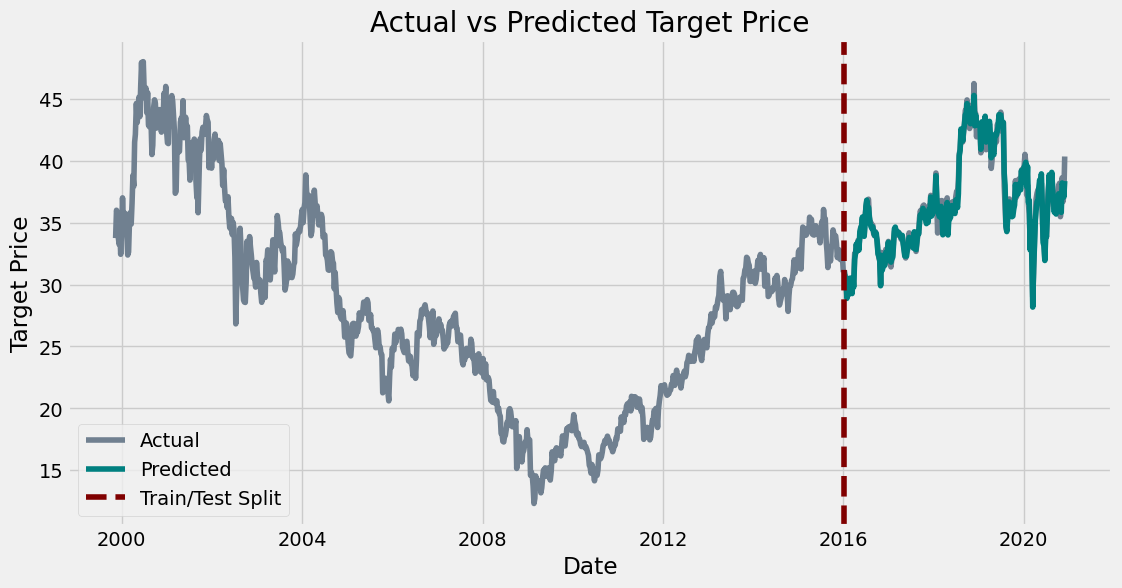

In [716]:
#Plot predicted prices vs. actual prices
plt.figure(figsize=(12, 6))
plt.plot(train['Target'], label='Actual', color='slategrey') 
plt.plot(test['Target'], color='slategrey')
plt.plot(test['Prediction'], label='Predicted', color='teal')
plt.xlabel('Date')
plt.ylabel('Target Price')
plt.title('Actual vs Predicted Target Price')
plt.axvline(pd.to_datetime('2016-01-06'), color='maroon', linestyle='--', label='Train/Test Split')
plt.legend()
plt.grid(True)
plt.show()

#### The graph displays a comparison of actual and predicted target prices over time. The predicted prices closely track the actual prices, indicating that the model used to generate these predictions is performing satisfactorily, with a Mean Absolute Error (MAE) of less than 0.4.

In [720]:
#Mean Absolute Error MAE 
mea = mean_absolute_error(y_test, y_pred)
mea

0.35752209573984145

In [722]:
#RMSE
rmse = np.sqrt(mea)
rmse

0.5979315142554718